In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

### Task 1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

## Реализация алгоритма kNN<a class='anchor' id='implement_knn'>

Подгрузка датасета и разбиение на обучающую и тестовую выборку

In [120]:
X, y = load_iris(return_X_y=True)
X = X[:, :2]

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=66, stratify=y)

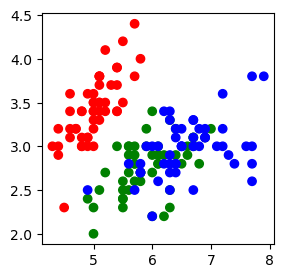

In [121]:
cmap = ListedColormap(['red', 'green', 'blue'])
plt.figure(figsize=(3, 3))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap);

Определение функций 

In [122]:
# расчёт l2-метрики
def l2_metrics(x1, x2):
    
    distance = np.sum(np.square(x1 - x2))

    return np.sqrt(distance)

In [123]:
# расчёт accuracy
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [124]:
# код KNN со взвешенными дистанциями
def knn(x_train, y_train, x_test, k):
    
    answers = []
    for x in x_test:
        test_distances = []
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до  объекта обучающей выборки
            distance = l2_metrics(x, x_train[i])
            
            # считаем веса и взвешанное растояние
            weight = 1/ (distance + 1)           
            weighted_dist = distance * weight
            
            # Записываем в список значение взвешенного расстояния и ответа на объекте обучающей выборки
            test_distances.append((weighted_dist, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Сортируем список и среди первых k элементов подсчитаем частоту появления разных классов
        for d in sorted(test_distances)[0:k]:
            classes[d[1]] += 1

        # Записываем в список ответов наиболее часто встречающийся класс
        answers.append(sorted(classes, key=classes.get)[-1])
        
    return answers

Проверим работу алгоритма при различных k

In [125]:
k = 4
y_pred = knn(X_train, y_train, X_test, k)

print(f'Точность алгоритма при k = {k}: {accuracy(y_pred, y_test):.3f}')

Точность алгоритма при k = 4: 0.711


### Task 2. Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутрикластерное расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

Создадим 2 датасета с разными std и разбием на обучающую и тестовую выборки

In [138]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=600, cluster_std=2, random_state=66)

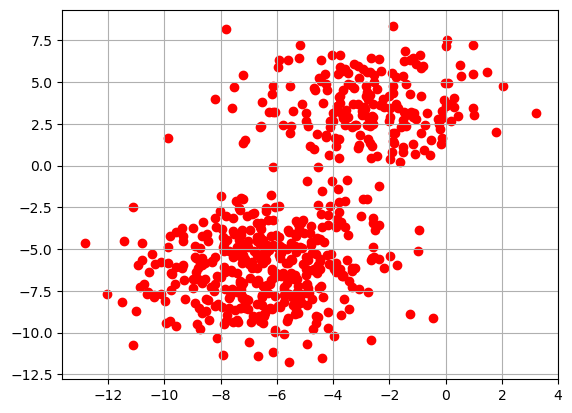

In [139]:
plt.scatter(X[:, 0], X[:, 1], color = 'r')
plt.grid()
plt.show()

Определение функций 

In [140]:
# k-means
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для кластеризации
    clusters = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # кластеризуем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [l2_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            cluster = distances.index(min(distances))
            clusters[cluster].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for cluster in clusters:
            centroids[cluster] = np.mean(clusters[cluster], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.linalg.norm(centroids[centroid] - old_centroids[centroid], ord=2) > min_distance:
                optimal = False
                break
        
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, clusters

In [141]:
def MSID(centroids, clusters):
    incuster_dist = []
    for i, cluster in clusters.items():
        cluster_dist = []
        for point in cluster:
            dist = l2_metrics(point, centroids[i])
            cluster_dist.append(dist)
        incuster_dist.append(np.mean(cluster_dist))
    return np.mean(incuster_dist)

In [142]:
%%time

msid_list = []

for k in range(1,11):
    centroids, clusters = kmeans(X, k = k, max_iterations = 20, min_distance =1e-4)
    msid = round(MSID(centroids, clusters),3)
    
    msid_list.append(msid)

Wall time: 45.4 s


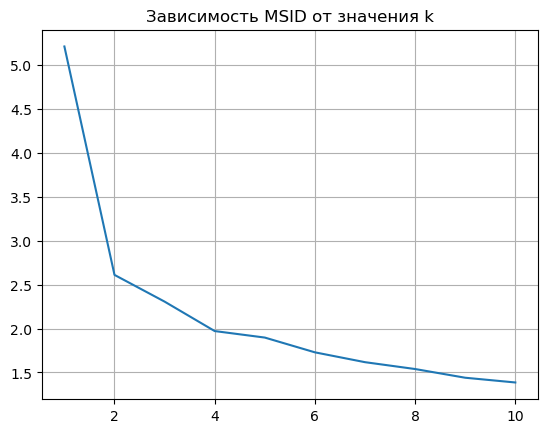

In [146]:
x = np.arange(1,11)
plt.title('Зависимость MSID от значения k')
plt.grid()
plt.plot(x,msid_list)